In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sci
import pandas as pd
import json
import ndjson
import jsonlines
import os
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
sys.path.append('..')
from ML import ml_utils, plottings
path = os.path.join(*ml_utils.split_path_unix_win('../../Data/pan19-celebrity-profiling-training-dataset-2019-01-31/predictions/workset/creator'))
agen = 'age'
gendern = 'gender'
order = ['dist', 'char', 'asis', 'pos', 'tag', 'dep', 'lemma', 'word','emoticon_c','polarity', 'num']
stackdirs = ['_'.join(order[:i]) for i in range(2, len(order)+1)] + ['dist_char_asis_lemma','dist_char_asis_lemma_word']
dirs = order + ['_'.join(order[:i]) for i in range(2, len(order)+1)] + ['dist_char_asis_lemma', 'dist_char_asis_lemma_word']

authors = [50, 150, 500, 1000]
lens = [100, 250, 500]
models = ['', 'direct', 'dynAA']

targets = ['age', 'gender']

featuretyp_dic = {'emoticon': [[100, 250, 500], [1], [1000, 500, 150, 50]],
                  'char': [[100, 250, 500], list(range(2, 5 + 1)), [1000, 500, 150, 50]],
                  'word': [[100, 250, 500], list(range(1, 2 + 1)), [1000, 500, 150, 50]],
                  'tag': [[100, 250, 500], list(range(1, 3 + 1)), [1000, 500, 150, 50]],
                  'dep': [[100, 250, 500], list(range(1, 3 + 1)), [1000, 500, 150, 50]],
                  'asis': [[100, 250, 500], list(range(2, 5 + 1)), [1000, 500, 150, 50]],
                  'lemma': [[100, 250, 500], list(range(1, 2 + 1)), [1000, 500, 150, 50]],
                  'dist': [[100, 250, 500], list(range(2, 5 + 1)), [1000, 500, 150, 50]],
                  'pos': [[100, 250, 500], list(range(1, 3 + 1)), [1000, 500, 150, 50]],
                  'num': [[100, 250, 500], [1], [1000, 500, 150, 50]],
                  'polarity': [[100, 250, 500], [1], [1000, 500, 150, 50]]
                      }


In [10]:
dats = {}
for target in targets:
    dats[target] = {}
    for minTw in [str(el) for el in lens]:
        dats[target][minTw]  = {}
        for model in models:
            if model in ['direct', 'dynAA']:

                tmpdirs = stackdirs
                settyp = ['test']
                key = 'stacked' if model == 'dynAA' else 'cumulated'
                filebeg = '{}_'.format(model)
                dats[target][minTw][key] = {}
            else:
                tmpdirs = order
                settyp = ['val', 'test']
                key = 'baseline'
                dats[target][minTw][key] = {}
                filebeg = ''
            for dir in tmpdirs:
                dir = re.sub('emoticon_c', 'emoticon', dir)
                part = dir.split('_')[-1]
                dir = re.sub('emoticon', 'emoticon_c', dir)
                grams = featuretyp_dic[part][1]
                dats[target][minTw][key][dir] = {}
                for subgram in [grams[0:i] for i in range(1, len(grams)+1)]:
                    sg = '_'.join([str(el) for el in subgram])
                    dats[target][minTw][key][dir][sg] = {}
                    for author in authors:
                        dats[target][minTw][key][dir][sg][str(author)] = []
                        for subset in settyp:
                            file = "{0}pred_{1}_{2}_{3}_{4}_{5}_{6}.json".format(filebeg,
                                                                                                                      subset,
                                                                                                                      target,
                                                                                                                      dir,
                                                                                                                      sg,
                                                                                                                      minTw,
                                                                                                                      author)
                            dats[target][minTw][key][dir][sg][str(author)].append(os.path.join(path, target, dir, minTw, file))




In [ ]:
savedir = os.path.join(*ml_utils.split_path_unix_win('../../tex/figures'))
redo =True
backend_ =  mpl.get_backend()
mpl.use("Agg")
for target in dats.keys():
    for mT in dats[target].keys():
        minTw = int(mT)
        os.makedirs(os.path.join(savedir, target, mT, 'proportions'), exist_ok=True)
        os.makedirs(os.path.join(savedir, target, mT, 'confusion'), exist_ok=True)
        for mode in dats[target][mT].keys():
            for dir in dats[target][mT][mode].keys():
                for grams in dats[target][mT][mode][dir].keys():
                    df = None
                    targCol = 'gender' if target == 'gender' else 'centered_age'
                    predCol = target + '_predicted_cat'

                    fp = os.path.join(savedir, target,mT,'confusion' ,
                                             'confusion_{}_{}_{}_{}_mode_major_only_false.pdf'.format(mode,
                                                                                          dir,
                                                                                          grams,
                                                                                            mT))

                    if os.path.exists(fp) and not redo:
                        continue

                    for author in sorted([int(el) for el in list(dats[target][mT][mode][dir][grams].keys())]):
                        author = str(author)
                        for file in dats[target][mT][mode][dir][grams][author]:
                            try:
                                tmp = pd.read_json(file)
                            except:
                                print('Loading file failed : {}'.format(file))
                                continue
                            sb = 'test' if 'test' in file else 'val'
                            tmp['# Authors'] =  int(author)
                            tmp['subset'] =  sb
                            if type(df) == type(None):
                                df = tmp
                            else:
                                df = pd.concat((df, tmp), axis=0)
                    df.reset_index(inplace=True, drop=True)
                    df['correct'] = df[targCol] == df[predCol]
                    if False:
                        fig, ax = plottings.plot_distrib_graph(df=df, to_plot='True_False', absolute=False)

                        fig.savefig(os.path.join(savedir, target,mT,'proportions' ,
                                                 'proportions_{}_{}_{}_{}_color_pred.pdf'.format(mode,
                                                                                              dir,
                                                                                              grams,
                                                                                              mT)),
                                    dpi=fig.dpi,transparent=True, bbox_inches='tight')

                        fig.savefig(os.path.join(savedir, target,mT,'proportions' ,
                                                 'proportions_{}_{}_{}_{}_color_pred.png'.format(mode,
                                                                                              dir,
                                                                                              grams,
                                                                                              mT)),
                                    dpi=fig.dpi,transparent=True, bbox_inches='tight')

                        fig, ax = plottings.plot_distrib_graph(df=df, to_plot='False', absolute=False,
                                                               color=targCol)
                        fig.savefig(os.path.join(savedir, target,mT,'proportions' ,
                                                 'proportions_{}_{}_{}_{}_color_{}.pdf'.format(mode,
                                                                                              dir,
                                                                                              grams,
                                                                                              mT,
                                                                                               targCol)),
                                    dpi=fig.dpi, transparent=True, bbox_inches='tight')

                        fig.savefig(os.path.join(savedir, target,mT,'proportions' ,
                                                 'proportions_{}_{}_{}_{}_color_{}.png'.format(mode,
                                                                                              dir,
                                                                                              grams,
                                                                                              mT,
                                                                                               targCol)),
                                    dpi=fig.dpi, transparent=True, bbox_inches='tight')
                    #plot basic confusion matrix
                    fig = plottings.plot_heatmap(df=df, target=targCol, pred=predCol,
                                                 major_wrong = False, normalize='true')
                    fig.savefig(os.path.join(savedir, target,mT,'confusion' ,
                                             'confusion_{}_{}_{}_{}_mode_basic.pdf'.format(mode,
                                                                                          dir,
                                                                                          grams,
                                                                                          mT)),
                                dpi=fig.dpi, transparent=True, bbox_inches='tight')



                    fig = plottings.plot_heatmap(df=df, target=targCol, pred=predCol,
                                                 major_wrong = True, normalize='all')
                    fig.savefig(os.path.join(savedir, target,mT,'confusion' ,
                                             'confusion_{}_{}_{}_{}_mode_major_false.pdf'.format(mode,
                                                                                          dir,
                                                                                          grams,
                                                                                          mT)),
                                dpi=fig.dpi, transparent=True, bbox_inches='tight')

                    fig = plottings.plot_heatmap(df=df, target=targCol, pred=predCol,
                                                 major_wrong = 'wrong', normalize='all')
                    fig.savefig(os.path.join(savedir, target,mT,'confusion' ,
                                             'confusion_{}_{}_{}_{}_mode_major_only_false.pdf'.format(mode,
                                                                                          dir,
                                                                                          grams,
                                                                                          mT)),
                                dpi=fig.dpi, transparent=True, bbox_inches='tight')
                    plt.clf()

mpl.use(backend_) # Reset backend

..\..\tex\figures\age\100\confusion\confusion_baseline_dist_2_100_mode_major_only_false.pdf
..\..\tex\figures\age\100\confusion\confusion_baseline_dist_2_3_100_mode_major_only_false.pdf
..\..\tex\figures\age\100\confusion\confusion_baseline_dist_2_3_4_100_mode_major_only_false.pdf
..\..\tex\figures\age\100\confusion\confusion_baseline_dist_2_3_4_5_100_mode_major_only_false.pdf
..\..\tex\figures\age\100\confusion\confusion_baseline_char_2_100_mode_major_only_false.pdf
..\..\tex\figures\age\100\confusion\confusion_baseline_char_2_3_100_mode_major_only_false.pdf
..\..\tex\figures\age\100\confusion\confusion_baseline_char_2_3_4_100_mode_major_only_false.pdf
..\..\tex\figures\age\100\confusion\confusion_baseline_char_2_3_4_5_100_mode_major_only_false.pdf
..\..\tex\figures\age\100\confusion\confusion_baseline_asis_2_100_mode_major_only_false.pdf
..\..\tex\figures\age\100\confusion\confusion_baseline_asis_2_3_100_mode_major_only_false.pdf
..\..\tex\figures\age\100\confusion\confusion_baseline

C:\Users\schubert\Documents\attributionfeatures\Scripts\ML\plottings.py:275: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, figsize=(18,4))
C:\Users\schubert\Documents\attributionfeatures\Scripts\ML\plottings.py:275: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, figsize=(18,4))
C:\Users\schubert\Documents\attributionfeatures\Scripts\ML\plottings.py:275: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

In [4]:
import warnings
warnings.filterwarnings('ignore')
savedir = os.path.join(*ml_utils.split_path_unix_win('../../tex/figures'))
redo =False
idx = ["500", "250", "100"]
only_do = ['age','gender']
backend_ =  mpl.get_backend()
mpl.use("Agg")
for target in dats.keys():
    if target in only_do:
        tweets = sorted(list(dats[target].keys()), key=idx.index)
        for mT in tweets:
            minTw = int(mT)
            os.makedirs(os.path.join(savedir, target, mT, 'bars'), exist_ok=True)
            os.makedirs(os.path.join(savedir, target, mT, 'confusion'), exist_ok=True)
            for mode in dats[target][mT].keys():
                for dir in dats[target][mT][mode].keys():
                    for grams in dats[target][mT][mode][dir].keys():
                        df = None
                        targCol = 'gender' if target == 'gender' else 'centered_age'
                        predCol = target + '_predicted_cat'

                        # fp = os.path.join(savedir, target,mT,'confusion' ,
                        #                          'confusion_{}_{}_{}_{}_mode_major_only_false.pdf'.format(mode,
                        #                                                                       dir,
                        #                                                                       grams,
                        #                                                                       mT)),
                        # if os.path.exists(fp) and not redo:
                        #     continue

                        for author in sorted([int(el) for el in list(dats[target][mT][mode][dir][grams].keys())]):
                            author = str(author)
                            for file in dats[target][mT][mode][dir][grams][author]:
                                try:
                                    tmp = pd.read_json(file)
                                except:
                                    print('Loading file failed : {}'.format(os.path.basename(file)))
                                    continue
                                sb = 'test' if 'test' in file else 'val'
                                tmp['# Authors'] =  int(author)
                                tmp['subset'] =  sb
                                if type(df) == type(None):
                                    df = tmp
                                else:
                                    df = pd.concat((df, tmp), axis=0)
                        print('Doing the stuff including {}'.format(os.path.basename(file)))
                        df.reset_index(inplace=True, drop=True)
                        df['correct'] = df[targCol] == df[predCol]
                        # fig, ax = plottings.plot_distrib_graph(df=df, to_plot='True_False', absolute=False, line=True)
                        #
                        # fig.savefig(os.path.join(savedir, target,mT,'bars' ,
                        #                          'proportions_{}_{}_{}_{}_color_pred.pdf'.format(mode,
                        #                                                                       dir,
                        #                                                                       grams,
                        #                                                                       mT)),
                        #             dpi=fig.dpi,transparent=True, bbox_inches='tight')
                        #
                        # fig.savefig(os.path.join(savedir, target,mT,'bars' ,
                        #                          'proportions_{}_{}_{}_{}_color_pred.png'.format(mode,
                        #                                                                       dir,
                        #                                                                       grams,
                        #                                                                       mT)),
                        #             dpi=fig.dpi,transparent=True, bbox_inches='tight')
                        #
                        # fig, ax = plottings.plot_distrib_graph(df=df, to_plot='False', absolute=False,
                        #                                        color=targCol, line=True)
                        # fig.savefig(os.path.join(savedir, target,mT,'bars' ,
                        #                          'proportions_{}_{}_{}_{}_color_{}.pdf'.format(mode,
                        #                                                                       dir,
                        #                                                                       grams,
                        #                                                                       mT,
                        #                                                                        targCol)),
                        #             dpi=fig.dpi, transparent=True, bbox_inches='tight')
                        #
                        # fig.savefig(os.path.join(savedir, target,mT,'bars' ,
                        #                          'proportions_{}_{}_{}_{}_color_{}.png'.format(mode,
                        #                                                                       dir,
                        #                                                                       grams,
                        #                                                                       mT,
                        #                                                                        targCol)),
                        #             dpi=fig.dpi, transparent=True, bbox_inches='tight')
                        #plot basic confusion matrix
                        fig = plottings.plot_heatmap(df=df, target=targCol, pred=predCol,
                                                     major_wrong = False, normalize='true')
                        fig.savefig(os.path.join(savedir, target,mT,'confusion' ,
                                                 'confusion_{}_{}_{}_{}_mode_basic.pdf'.format(mode,
                                                                                              dir,
                                                                                              grams,
                                                                                              mT)),
                                    dpi=fig.dpi, bbox_inches='tight')



                        fig = plottings.plot_heatmap(df=df, target=targCol, pred=predCol,
                                                     major_wrong = True, normalize='all')
                        fig.savefig(os.path.join(savedir, target,mT,'confusion' ,
                                                 'confusion_{}_{}_{}_{}_mode_major_false.pdf'.format(mode,
                                                                                              dir,
                                                                                              grams,
                                                                                              mT)),
                                    dpi=fig.dpi, bbox_inches='tight')

                        fig = plottings.plot_heatmap(df=df, target=targCol, pred=predCol,
                                                     major_wrong = 'wrong', normalize='all')
                        #fig.savefig(os.path.join(savedir, target,mT,'confusion' ,
                        #                         'confusion_{}_{}_{}_{}_mode_major_only_false.pdf'.format(mode,
                        #                                                                      dir,
                        #                                                                      grams,
                        #                                                                      mT)),
                        #            dpi=fig.dpi, bbox_inches='tight')
                        plt.clf()


mpl.use(backend_) # Reset backend

Doing the stuff including pred_test_age_dist_2_500_1000.json
Doing the stuff including pred_test_age_dist_2_3_500_1000.json
Doing the stuff including pred_test_age_dist_2_3_4_500_1000.json
Doing the stuff including pred_test_age_dist_2_3_4_5_500_1000.json
Doing the stuff including pred_test_age_char_2_500_1000.json
Doing the stuff including pred_test_age_char_2_3_500_1000.json
Doing the stuff including pred_test_age_char_2_3_4_500_1000.json
Doing the stuff including pred_test_age_char_2_3_4_5_500_1000.json
Doing the stuff including pred_test_age_asis_2_500_1000.json
Doing the stuff including pred_test_age_asis_2_3_500_1000.json
Doing the stuff including pred_test_age_asis_2_3_4_500_1000.json
Doing the stuff including pred_test_age_asis_2_3_4_5_500_1000.json
Doing the stuff including pred_test_age_pos_1_500_1000.json
Doing the stuff including pred_test_age_pos_1_2_500_1000.json
Doing the stuff including pred_test_age_pos_1_2_3_500_1000.json
Doing the stuff including pred_test_age_tag_1_

In [6]:
target = 'gender'
minTw = '100'
dir = 'asis'
mode = 'baseline'
grams = '2_3_4_5'
df = None
targCol = 'gender' if target == 'gender' else 'centered_age'
predCol = target + '_predicted_cat'
for author in sorted([int(el) for el in list(dats[target][minTw][mode][dir][grams].keys())]):
    author = str(author)
    for file in dats[target][minTw][mode][dir][grams][author]:
        tmp = pd.read_json(file)
        sb = 'test' if 'test' in file else 'val'
        tmp['# Authors'] =  int(author)
        tmp['subset'] =  sb
        if type(df) == type(None):
            df = tmp
        else:
            df = pd.concat((df, tmp), axis=0)
df.reset_index(inplace=True, drop=True)


In [4]:
tmp = df[0:100000].copy(deep=True)

In [7]:
df['correct'] = df[targCol] == df[predCol]
def prop(x):
    labs = x.unique()

    return round(sum(x == labs[0])/len(x),2)
df.groupby('# Authors').agg({'gender':prop,
                             'centered_age':prop})
#tmp['correct'] = tmp[targCol] == tmp[predCol]

#fig, ax = plottings.plot_distrib_graph(df=df, to_plot='True_False', absolute=False)

gender  centered_age
# Authors                      
50            0.5          0.17
150           0.5          0.13
500           0.5          0.17
1000          0.5          0.17

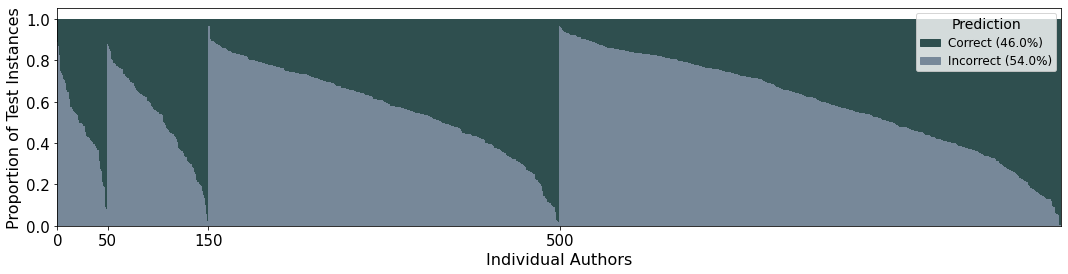

In [19]:
fig, ax= plottings.plot_distrib_graph(df=df, to_plot='True_False', absolute=False, line=True, color='correct')



<ipython-input-8-0f9d779d5d95>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


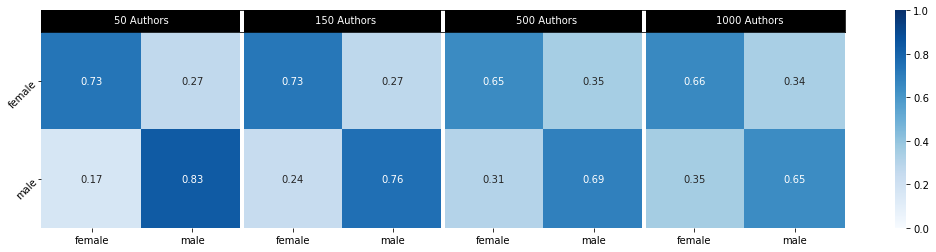

In [8]:
fig = plottings.plot_heatmap(df=df, target=targCol, pred=predCol, major_wrong = False, normalize='true')
fig.show()
#fig.savefig(os.path.join(savedir, target,str(100),'confusion' ,'test.pdf'),
#                                    dpi=fig.dpi, bbox_inches='tight')

In [63]:
def counter(x):
    return len(x.unique())
df.groupby(by='# Authors').agg({'ID':counter})



ID
# Authors      
50           50
150         150
500         500
1000       1000